### Apprentissage profond - TD n°2
__________
Architectures DNN classiques appliquées à la classification de chiffres avec MNIST

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# we use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Données et problème

On réutilise le dataset MNIST déjà téléchargé au TD précédent. Cette fois-ci, on va charger les données avec le module `Dataloader` de pytorch.

In [5]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

my_data_path = r'C:\\data\\TDDL-master\\data'
train_set = datasets.MNIST( my_data_path, train=True, transform=trans, download=True )
test_set = datasets.MNIST( my_data_path, train=False, transform=trans, download=True )


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1621679.32it/s]


Extracting C:\\data\\TDDL-master\\data\MNIST\raw\train-images-idx3-ubyte.gz to C:\\data\\TDDL-master\\data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 331266.00it/s]


Extracting C:\\data\\TDDL-master\\data\MNIST\raw\train-labels-idx1-ubyte.gz to C:\\data\\TDDL-master\\data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1843973.16it/s]


Extracting C:\\data\\TDDL-master\\data\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\\data\\TDDL-master\\data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting C:\\data\\TDDL-master\\data\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\\data\\TDDL-master\\data\MNIST\raw



Consulter la [documentation PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) à propos des modules `Dataset` et `Dataloader`.

NB : en pratique, on pourra définir [son propre dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) pour un cas d'utilisation donné.

In [6]:
# attributs du train set
var = vars(train_set)
for key in var.keys() : 
    print(key, type(var[key]))

print(train_set.data.shape)
print(train_set.targets.shape)

root <class 'str'>
transform <class 'torchvision.transforms.transforms.Compose'>
target_transform <class 'NoneType'>
transforms <class 'torchvision.datasets.vision.StandardTransform'>
train <class 'bool'>
data <class 'torch.Tensor'>
targets <class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.Size([60000])


In [7]:
# define data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))


total training batch number: 600
total testing batch number: 100


In [8]:
# attributs du train loader
var = vars(train_loader)
for key in var.keys() : 
    print(key, type(var[key]))

dataset <class 'torchvision.datasets.mnist.MNIST'>
num_workers <class 'int'>
prefetch_factor <class 'NoneType'>
pin_memory <class 'bool'>
pin_memory_device <class 'str'>
timeout <class 'int'>
worker_init_fn <class 'NoneType'>
_DataLoader__multiprocessing_context <class 'NoneType'>
_dataset_kind <class 'int'>
batch_size <class 'int'>
drop_last <class 'bool'>
sampler <class 'torch.utils.data.sampler.RandomSampler'>
batch_sampler <class 'torch.utils.data.sampler.BatchSampler'>
generator <class 'NoneType'>
collate_fn <class 'function'>
persistent_workers <class 'bool'>
_DataLoader__initialized <class 'bool'>
_IterableDataset_len_called <class 'NoneType'>
_iterator <class 'NoneType'>


Visualisation des images en utilisant le chargement des données avec `Dataloader`.

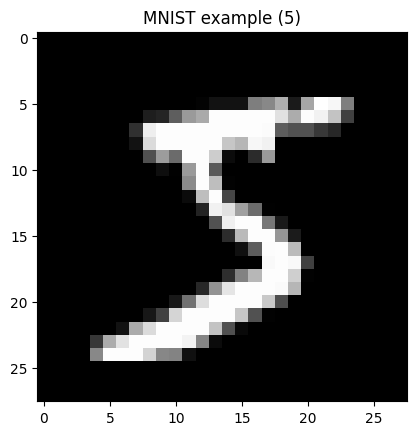

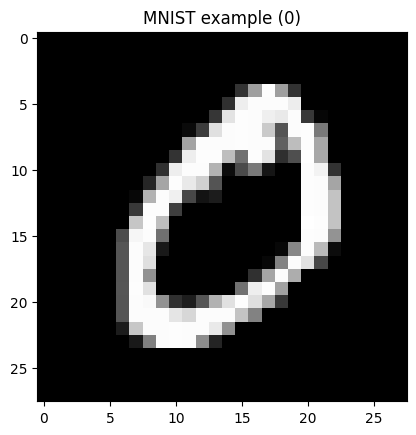

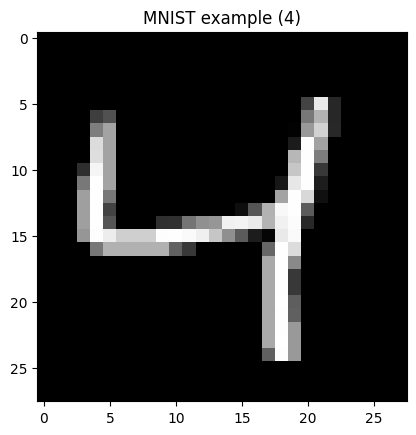

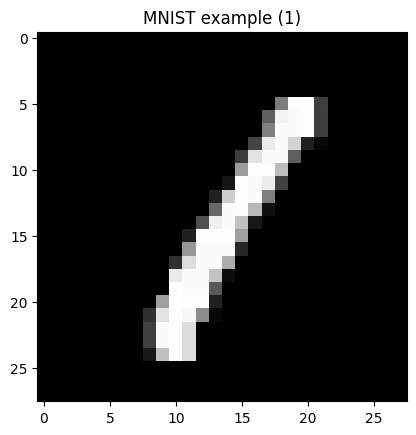

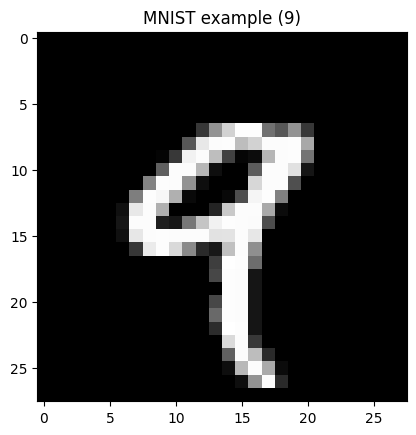

In [9]:
# display some images
# for an alternative see https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
for ii in range(5):
    imshow(train_set.data[ii] , title='MNIST example ({})'.format(train_set.targets[ii]) )
plt.close()

### Modélisation MLP

On commence par définir les tailles d'entrée et de sortie du réseau.

In [10]:
# définition des tailles d'entrée et de sortie
DATA_SIZE = 784 # 28 * 28 pixels
NUM_CLASSES = 10 # 10 classes

__Régression softmax__

Implémentation d'une classe `RegSoftNet` pour apprendre un modèle de régression softmax (généralisation à >  2 classesde la régression logistique).

Ici on utilise simplement 1 couche cachée.

In [11]:
class RegSoftNet(nn.Module):
    def __init__(self):
        super(RegSoftNet, self).__init__()
        self.fc = nn.Linear(DATA_SIZE,NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # passer de 28*28 à  (784,)
        x = F.relu(self.fc(x))
        return x

In [12]:
model = RegSoftNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

NB : Utilisation de model.train(), model.eval(), et with torch.no_grad()
* model.train() active les couches de type "dropout" ou "batchnorm". __Par défaut, tous les modules sont initialisés avec `train = True`__.
* model.eval() désactive la mise à jour des couches de type "dropout" ou "batchnorm".
* with torch.no_grad() économise de la mémoire et du temps de calcul au moment de l'inférence, dans la mesure où cela désactive la stockage des valeurs intermédiaires dans le graphe de calcul. Conserver en mémoire ces valeurs intermédiaires est utile pour effectuer la rétropropagation, mais inutile à l'inférence.

epoch 0 batch 0 [0/60000] training loss: 2.3957390785217285
epoch 0 batch 100 [10000/60000] training loss: 0.40514078736305237
epoch 0 batch 200 [20000/60000] training loss: 0.4414922595024109
epoch 0 batch 300 [30000/60000] training loss: 0.27424564957618713
epoch 0 batch 400 [40000/60000] training loss: 0.42011305689811707
epoch 0 batch 500 [50000/60000] training loss: 0.3599661588668823
Test Accuracy: 9159/10000 (tx 91.59%, err 8.41%)



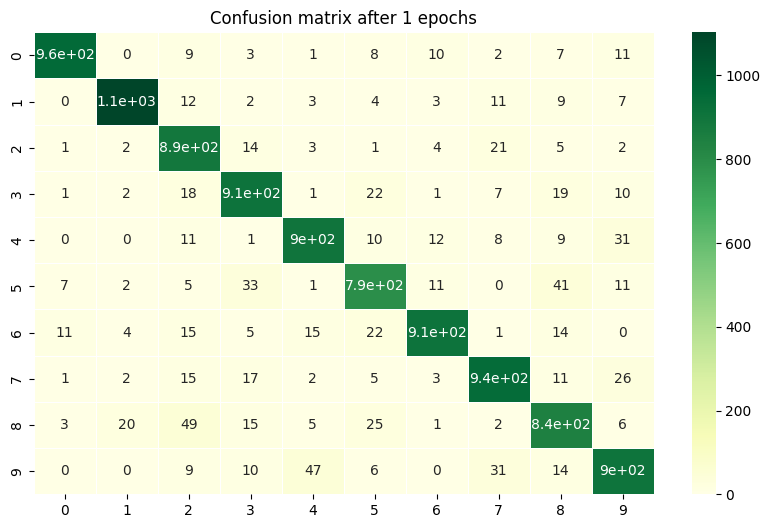

epoch 1 batch 0 [0/60000] training loss: 0.15399689972400665
epoch 1 batch 100 [10000/60000] training loss: 0.3697241246700287
epoch 1 batch 200 [20000/60000] training loss: 0.24845820665359497
epoch 1 batch 300 [30000/60000] training loss: 0.25505855679512024
epoch 1 batch 400 [40000/60000] training loss: 0.41492465138435364
epoch 1 batch 500 [50000/60000] training loss: 0.3156775236129761
Test Accuracy: 9202/10000 (tx 92.02%, err 7.98%)



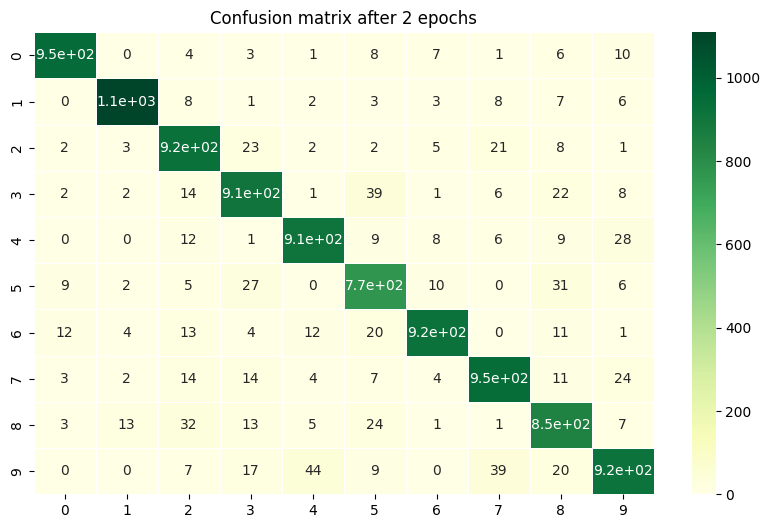

epoch 2 batch 0 [0/60000] training loss: 0.45193737745285034
epoch 2 batch 100 [10000/60000] training loss: 0.2857705354690552
epoch 2 batch 200 [20000/60000] training loss: 0.326106995344162
epoch 2 batch 300 [30000/60000] training loss: 0.28940287232398987
epoch 2 batch 400 [40000/60000] training loss: 0.364121675491333
epoch 2 batch 500 [50000/60000] training loss: 0.3649911880493164
Test Accuracy: 9213/10000 (tx 92.13%, err 7.87%)



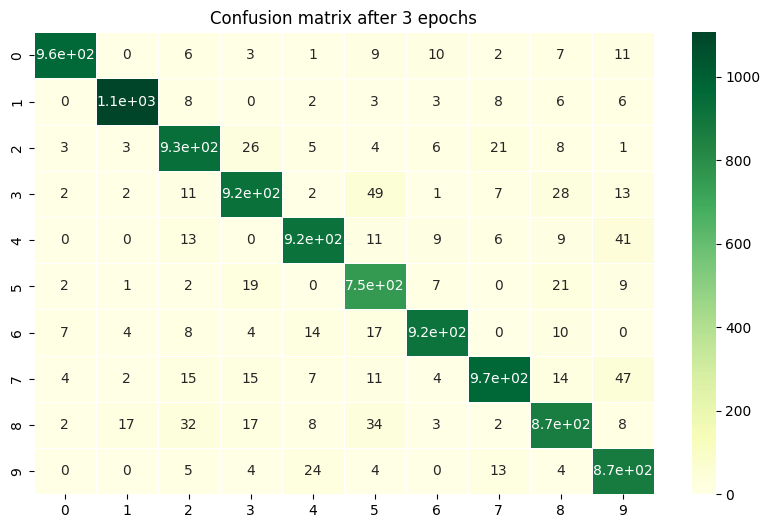

epoch 3 batch 0 [0/60000] training loss: 0.25847524404525757
epoch 3 batch 100 [10000/60000] training loss: 0.4231787621974945
epoch 3 batch 200 [20000/60000] training loss: 0.3492966890335083
epoch 3 batch 300 [30000/60000] training loss: 0.17651864886283875
epoch 3 batch 400 [40000/60000] training loss: 0.23341234028339386
epoch 3 batch 500 [50000/60000] training loss: 0.19388547539710999
Test Accuracy: 9213/10000 (tx 92.13%, err 7.87%)



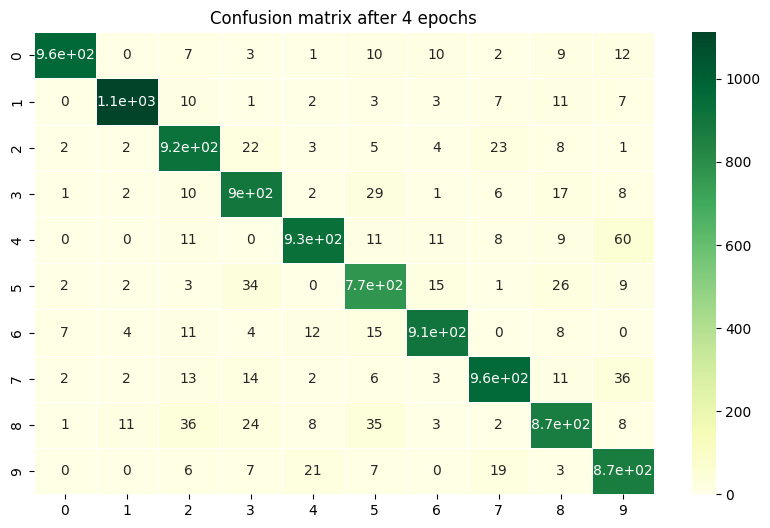

epoch 4 batch 0 [0/60000] training loss: 0.21500734984874725
epoch 4 batch 100 [10000/60000] training loss: 0.23951780796051025
epoch 4 batch 200 [20000/60000] training loss: 0.2488608956336975
epoch 4 batch 300 [30000/60000] training loss: 0.16935943067073822
epoch 4 batch 400 [40000/60000] training loss: 0.3741806149482727
epoch 4 batch 500 [50000/60000] training loss: 0.39523831009864807
Test Accuracy: 9232/10000 (tx 92.32%, err 7.68%)



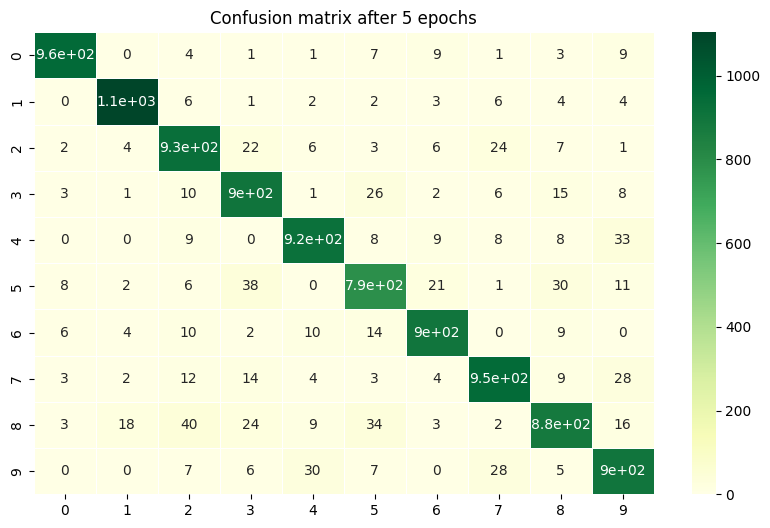

epoch 5 batch 0 [0/60000] training loss: 0.24430733919143677
epoch 5 batch 100 [10000/60000] training loss: 0.23691163957118988
epoch 5 batch 200 [20000/60000] training loss: 0.37433922290802
epoch 5 batch 300 [30000/60000] training loss: 0.39554110169410706
epoch 5 batch 400 [40000/60000] training loss: 0.230605810880661
epoch 5 batch 500 [50000/60000] training loss: 0.3657713830471039
Test Accuracy: 9247/10000 (tx 92.47%, err 7.53%)



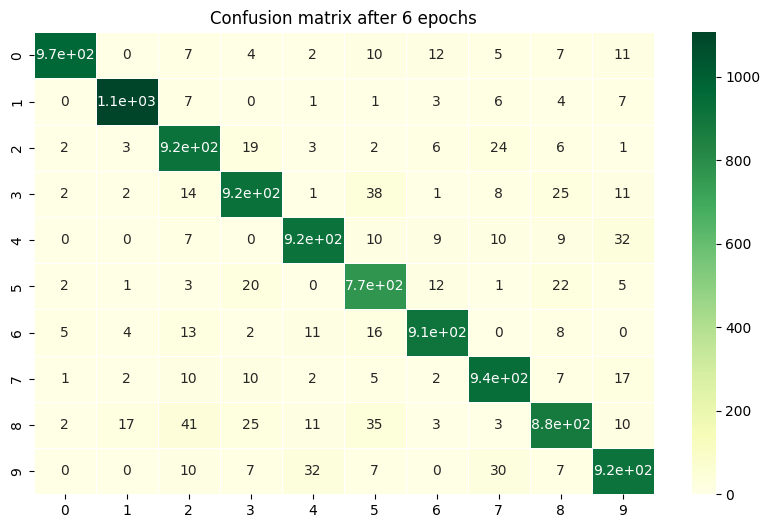

epoch 6 batch 0 [0/60000] training loss: 0.3550713360309601
epoch 6 batch 100 [10000/60000] training loss: 0.20801010727882385
epoch 6 batch 200 [20000/60000] training loss: 0.24922189116477966
epoch 6 batch 300 [30000/60000] training loss: 0.3129819333553314
epoch 6 batch 400 [40000/60000] training loss: 0.15407873690128326
epoch 6 batch 500 [50000/60000] training loss: 0.2195470780134201
Test Accuracy: 9226/10000 (tx 92.26%, err 7.74%)



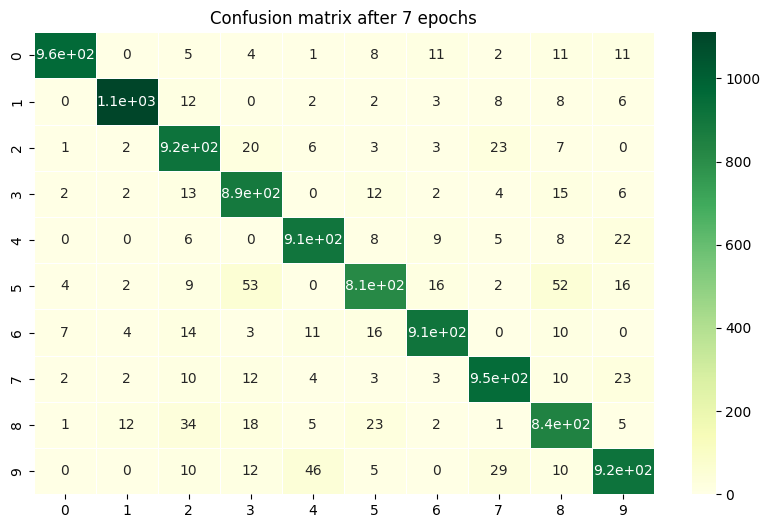

epoch 7 batch 0 [0/60000] training loss: 0.24518398940563202
epoch 7 batch 100 [10000/60000] training loss: 0.22748421132564545
epoch 7 batch 200 [20000/60000] training loss: 0.2895859479904175
epoch 7 batch 300 [30000/60000] training loss: 0.1251336932182312
epoch 7 batch 400 [40000/60000] training loss: 0.38354140520095825
epoch 7 batch 500 [50000/60000] training loss: 0.15723386406898499
Test Accuracy: 9244/10000 (tx 92.44%, err 7.56%)



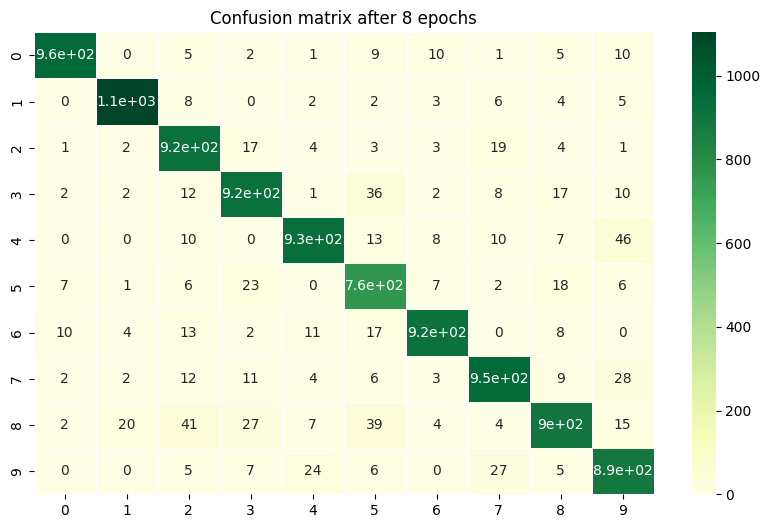

epoch 8 batch 0 [0/60000] training loss: 0.2959371507167816
epoch 8 batch 100 [10000/60000] training loss: 0.2838355004787445
epoch 8 batch 200 [20000/60000] training loss: 0.22190123796463013
epoch 8 batch 300 [30000/60000] training loss: 0.27180588245391846
epoch 8 batch 400 [40000/60000] training loss: 0.21919292211532593
epoch 8 batch 500 [50000/60000] training loss: 0.313200980424881
Test Accuracy: 9263/10000 (tx 92.63%, err 7.37%)



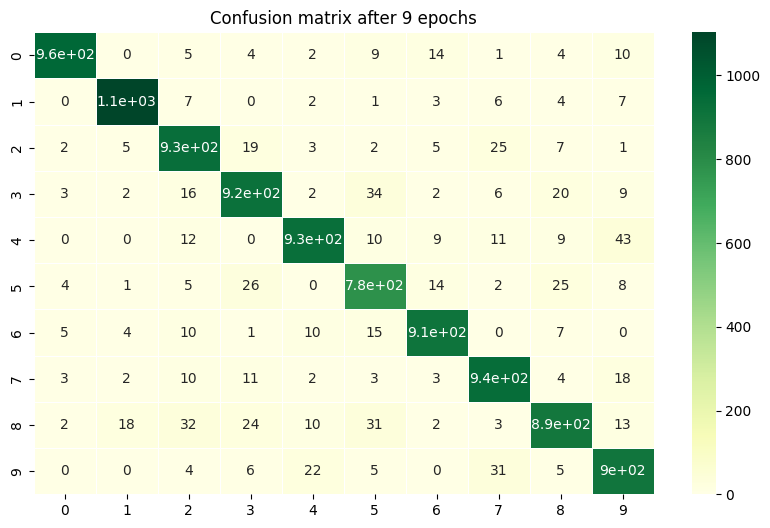

epoch 9 batch 0 [0/60000] training loss: 0.26980507373809814
epoch 9 batch 100 [10000/60000] training loss: 0.22216129302978516
epoch 9 batch 200 [20000/60000] training loss: 0.3797236979007721
epoch 9 batch 300 [30000/60000] training loss: 0.22748683393001556
epoch 9 batch 400 [40000/60000] training loss: 0.21461842954158783
epoch 9 batch 500 [50000/60000] training loss: 0.2925218641757965
Test Accuracy: 9263/10000 (tx 92.63%, err 7.37%)



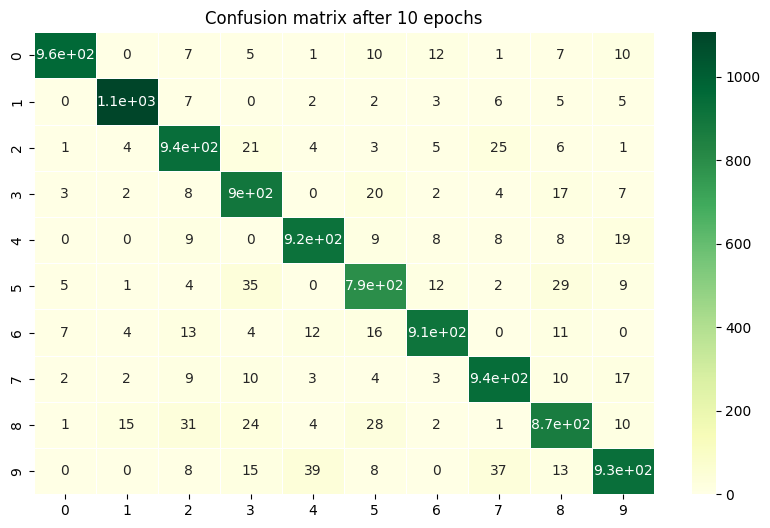

In [13]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    #print(confusion)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(confusion, annot=True,  linewidths=.5, cmap='YlGn')
    plt.title(f"Confusion matrix after {epoch+1} epochs")
    plt.show()
    plt.close()

__Perceptron multi-couche__

On utilise ici 2 couches cachées.

In [14]:
NUM_HIDDEN_1 = 256
NUM_HIDDEN_2 = 256

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(DATA_SIZE, NUM_HIDDEN_1)
        self.fc2 = nn.Linear(NUM_HIDDEN_1, NUM_HIDDEN_2)
        self.fc3 = nn.Linear(NUM_HIDDEN_2, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = MLPNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# redéfinir l'optimiseur ! 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

A nouveau, on entraine le modèle et on affiche au fur et à mesure des "epochs" la matrice de confusion sur les données d'évaluation. 

epoch 0 batch 0 [0/60000] training loss: 2.2998085021972656
epoch 0 batch 100 [10000/60000] training loss: 0.41500481963157654
epoch 0 batch 200 [20000/60000] training loss: 0.2719895541667938
epoch 0 batch 300 [30000/60000] training loss: 0.2712835669517517
epoch 0 batch 400 [40000/60000] training loss: 0.2019561231136322
epoch 0 batch 500 [50000/60000] training loss: 0.16765998303890228
Test Accuracy: 9392/10000 (tx 93.92%, err 6.08%)



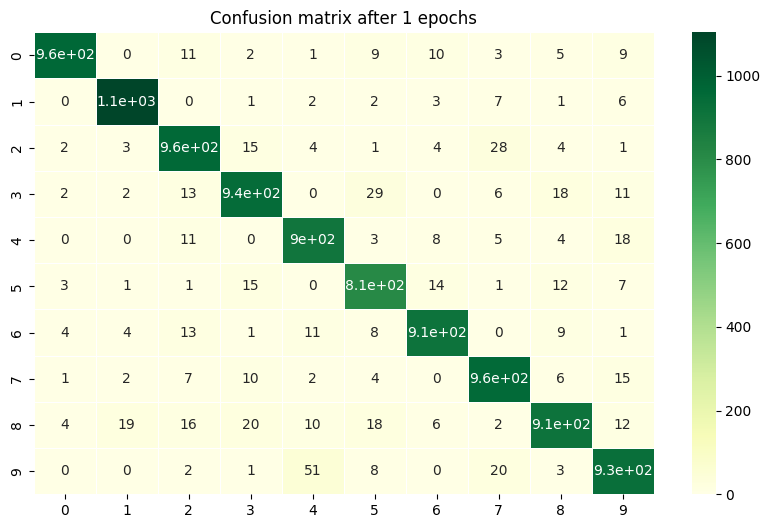

epoch 1 batch 0 [0/60000] training loss: 0.159667506814003
epoch 1 batch 100 [10000/60000] training loss: 0.18594449758529663
epoch 1 batch 200 [20000/60000] training loss: 0.17207522690296173
epoch 1 batch 300 [30000/60000] training loss: 0.1341491937637329
epoch 1 batch 400 [40000/60000] training loss: 0.24279887974262238
epoch 1 batch 500 [50000/60000] training loss: 0.07279863953590393
Test Accuracy: 9572/10000 (tx 95.72%, err 4.28%)



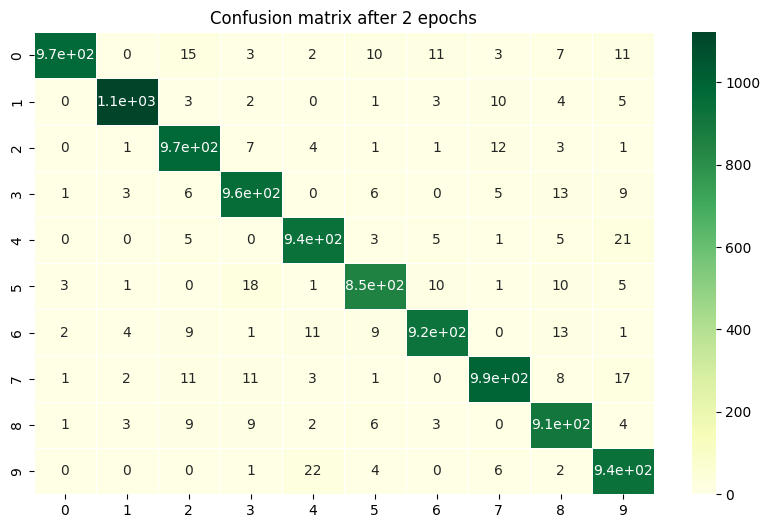

epoch 2 batch 0 [0/60000] training loss: 0.1531534045934677
epoch 2 batch 100 [10000/60000] training loss: 0.13889628648757935
epoch 2 batch 200 [20000/60000] training loss: 0.1854124665260315
epoch 2 batch 300 [30000/60000] training loss: 0.12671566009521484
epoch 2 batch 400 [40000/60000] training loss: 0.17791850864887238
epoch 2 batch 500 [50000/60000] training loss: 0.18897193670272827
Test Accuracy: 9640/10000 (tx 96.40%, err 3.60%)



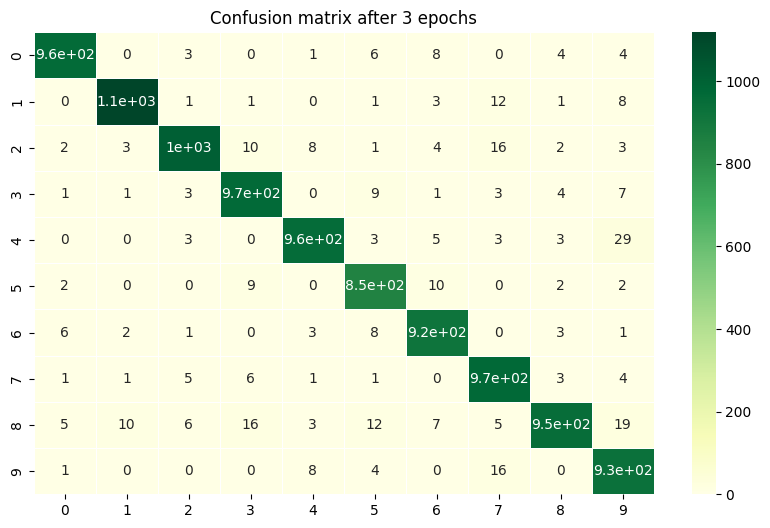

epoch 3 batch 0 [0/60000] training loss: 0.10598885267972946
epoch 3 batch 100 [10000/60000] training loss: 0.20428554713726044
epoch 3 batch 200 [20000/60000] training loss: 0.060287829488515854
epoch 3 batch 300 [30000/60000] training loss: 0.033611346036195755
epoch 3 batch 400 [40000/60000] training loss: 0.10199425369501114
epoch 3 batch 500 [50000/60000] training loss: 0.1400519162416458
Test Accuracy: 9698/10000 (tx 96.98%, err 3.02%)



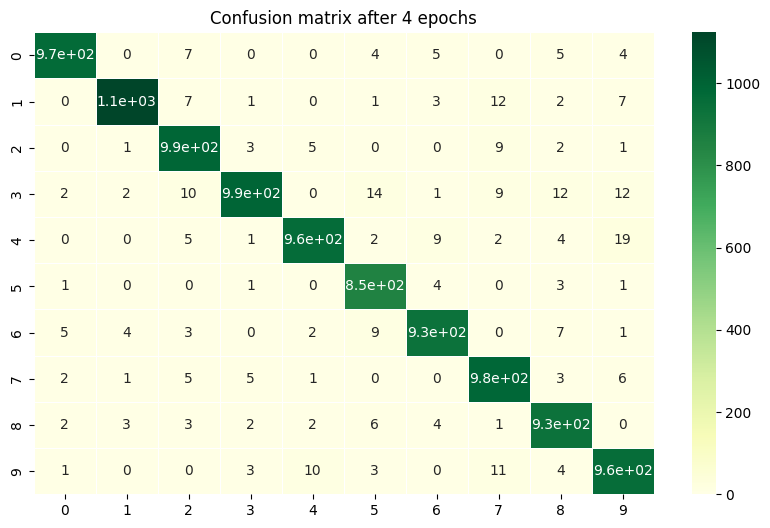

epoch 4 batch 0 [0/60000] training loss: 0.11937905102968216
epoch 4 batch 100 [10000/60000] training loss: 0.06592481583356857
epoch 4 batch 200 [20000/60000] training loss: 0.09119172394275665
epoch 4 batch 300 [30000/60000] training loss: 0.1028653234243393
epoch 4 batch 400 [40000/60000] training loss: 0.060074906796216965
epoch 4 batch 500 [50000/60000] training loss: 0.06879952549934387
Test Accuracy: 9749/10000 (tx 97.49%, err 2.51%)



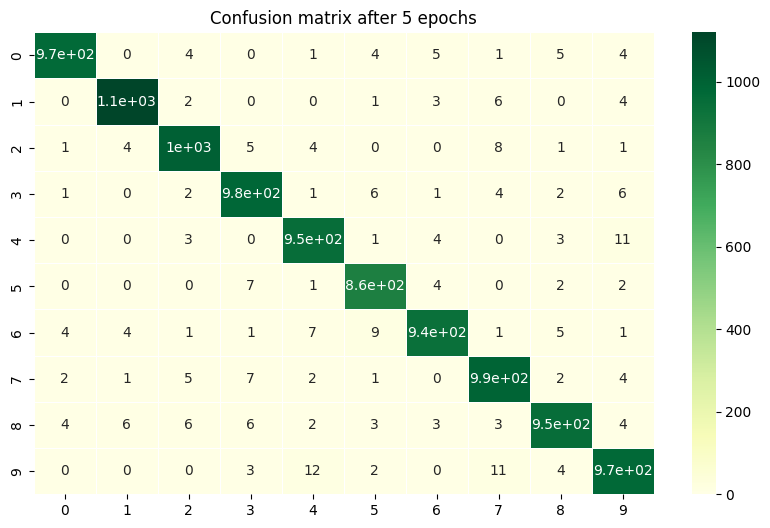

epoch 5 batch 0 [0/60000] training loss: 0.030218133702874184
epoch 5 batch 100 [10000/60000] training loss: 0.08222842216491699
epoch 5 batch 200 [20000/60000] training loss: 0.09806960076093674
epoch 5 batch 300 [30000/60000] training loss: 0.03871407359838486
epoch 5 batch 400 [40000/60000] training loss: 0.10190369933843613
epoch 5 batch 500 [50000/60000] training loss: 0.02283015102148056
Test Accuracy: 9770/10000 (tx 97.70%, err 2.30%)



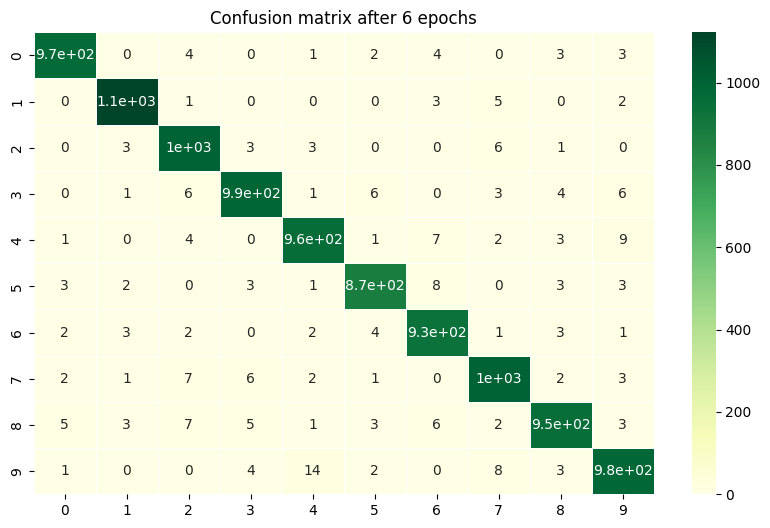

epoch 6 batch 0 [0/60000] training loss: 0.1055564284324646
epoch 6 batch 100 [10000/60000] training loss: 0.03198559209704399
epoch 6 batch 200 [20000/60000] training loss: 0.06113924831151962
epoch 6 batch 300 [30000/60000] training loss: 0.08641144633293152
epoch 6 batch 400 [40000/60000] training loss: 0.010499234311282635
epoch 6 batch 500 [50000/60000] training loss: 0.04105789214372635
Test Accuracy: 9779/10000 (tx 97.79%, err 2.21%)



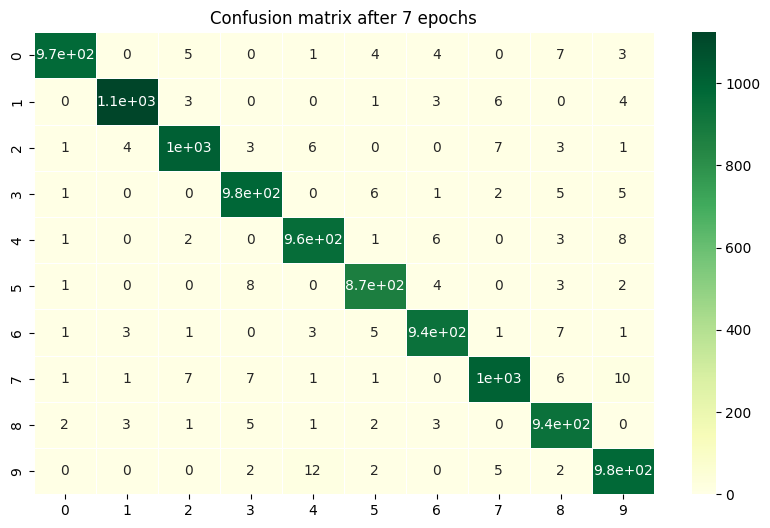

epoch 7 batch 0 [0/60000] training loss: 0.036531977355480194
epoch 7 batch 100 [10000/60000] training loss: 0.035006582736968994
epoch 7 batch 200 [20000/60000] training loss: 0.1069580465555191
epoch 7 batch 300 [30000/60000] training loss: 0.044513482600450516
epoch 7 batch 400 [40000/60000] training loss: 0.06733283400535583
epoch 7 batch 500 [50000/60000] training loss: 0.053889814764261246
Test Accuracy: 9780/10000 (tx 97.80%, err 2.20%)



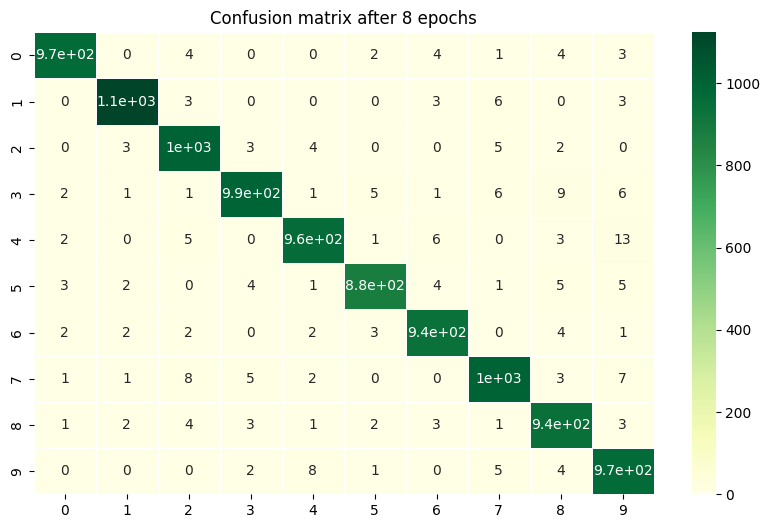

epoch 8 batch 0 [0/60000] training loss: 0.019620845094323158
epoch 8 batch 100 [10000/60000] training loss: 0.03465781360864639
epoch 8 batch 200 [20000/60000] training loss: 0.03016333281993866
epoch 8 batch 300 [30000/60000] training loss: 0.04709627106785774
epoch 8 batch 400 [40000/60000] training loss: 0.04373912513256073
epoch 8 batch 500 [50000/60000] training loss: 0.06306639313697815
Test Accuracy: 9791/10000 (tx 97.91%, err 2.09%)



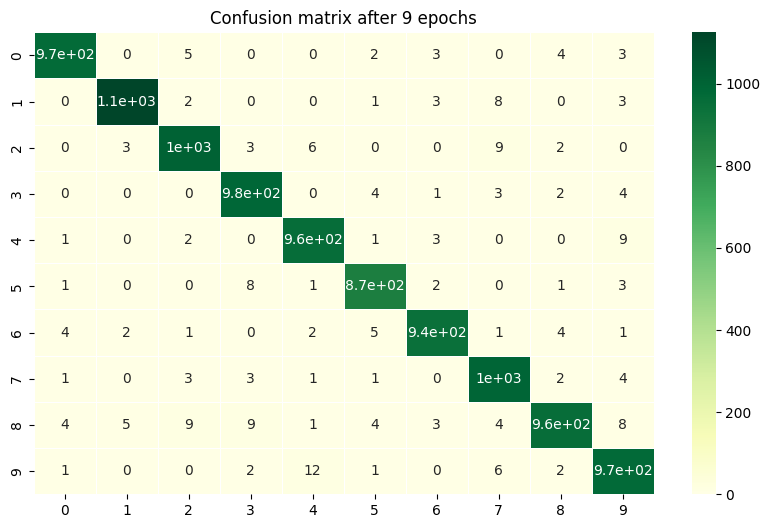

epoch 9 batch 0 [0/60000] training loss: 0.028622660785913467
epoch 9 batch 100 [10000/60000] training loss: 0.0317300520837307
epoch 9 batch 200 [20000/60000] training loss: 0.038605690002441406
epoch 9 batch 300 [30000/60000] training loss: 0.029443075880408287
epoch 9 batch 400 [40000/60000] training loss: 0.06651361286640167
epoch 9 batch 500 [50000/60000] training loss: 0.01555449329316616
Test Accuracy: 9795/10000 (tx 97.95%, err 2.05%)



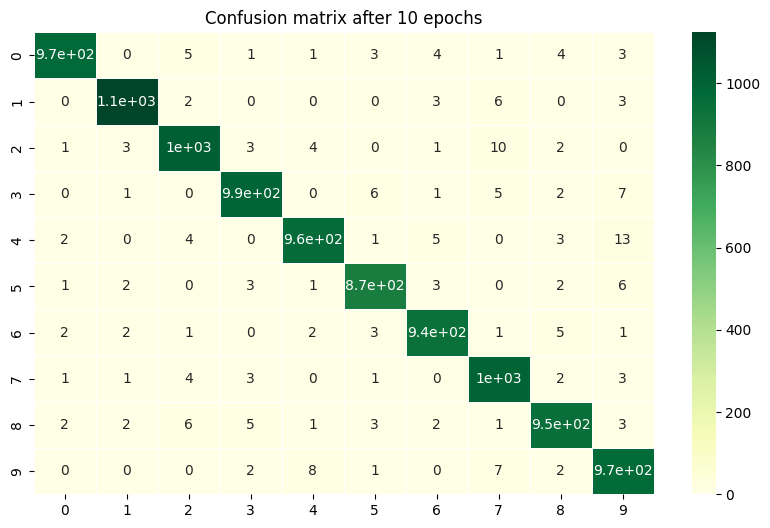

In [16]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    #print(confusion)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(confusion, annot=True,  linewidths=.5, cmap='YlGn')
    plt.title(f"Confusion matrix after {epoch+1} epochs")
    plt.show()
    plt.close()

### Modélisation CNN

Consulter la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d) de la class `Conv2D`.

> class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

Taille d'entrée : (N,Cin,H,W) x (N,Cin​,H,W) 

Taille de sortie : (N,Cout,Hout,Wout) x (N,Cout​,Hout​,Wout​)

avec : 
* N : batch size
* Cin et Cout : nombre de filtres respectivement en entrée et sortie (channels)
* H et W : height and width des filtres en entrée
* Hout et Wout : height and width des filtres en sortie

Attention : calcul des dimensions de sortie des couches de convolution et de pooling.

In [17]:
# Implémentation d'un CNN avec deux couches convolutives
# v1 sans Dropout
# v2 ajouter une couche de Dropout après les 2 couches de conv

NUM_CONV_1=32 # try 32
NUM_CONV_2=64 # try 64
NUM_FC=1024 # try 1024

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,NUM_CONV_1,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        # self.drop = nn.Dropout2d()
        self.fc_1 = nn.Linear(4*4*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        # x = F.relu(self.drop(self.conv_2(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,4*4*NUM_CONV_2) # Car 2 2d pooling !!! On veut applatir la matrice en vecteur pour avoir un vrai output
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

NB : de manière équivalente, en utilisant `loss = F.nll_loss(output, target)` au lieu de `loss = CrossEntropyLoss()` on peut écrire :

> return F.log_softmax(x, dim=1)

In [18]:
model = CNNNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05) # try lr=0.01, momentum=0.9
loss_fn = nn.CrossEntropyLoss()

epoch 0 batch 0 [0/60000] training loss: 2.292078971862793
epoch 0 batch 100 [10000/60000] training loss: 0.40771034359931946
epoch 0 batch 200 [20000/60000] training loss: 0.21550439298152924
epoch 0 batch 300 [30000/60000] training loss: 0.2892446517944336
epoch 0 batch 400 [40000/60000] training loss: 0.0689636692404747
epoch 0 batch 500 [50000/60000] training loss: 0.08660995215177536
Test Accuracy: 9777/10000 (tx 97.77%, err 2.23%)



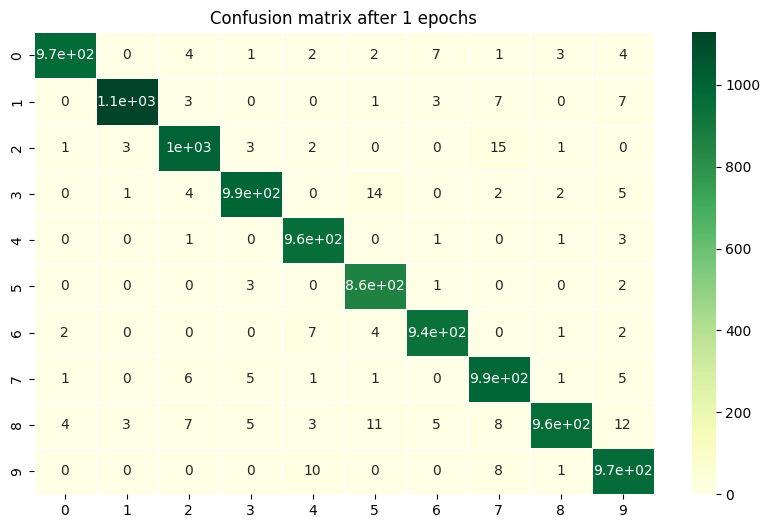

epoch 1 batch 0 [0/60000] training loss: 0.06018596515059471
epoch 1 batch 100 [10000/60000] training loss: 0.028009923174977303
epoch 1 batch 200 [20000/60000] training loss: 0.04786132648587227
epoch 1 batch 300 [30000/60000] training loss: 0.07939984649419785
epoch 1 batch 400 [40000/60000] training loss: 0.03710445389151573
epoch 1 batch 500 [50000/60000] training loss: 0.020026184618473053
Test Accuracy: 9843/10000 (tx 98.43%, err 1.57%)



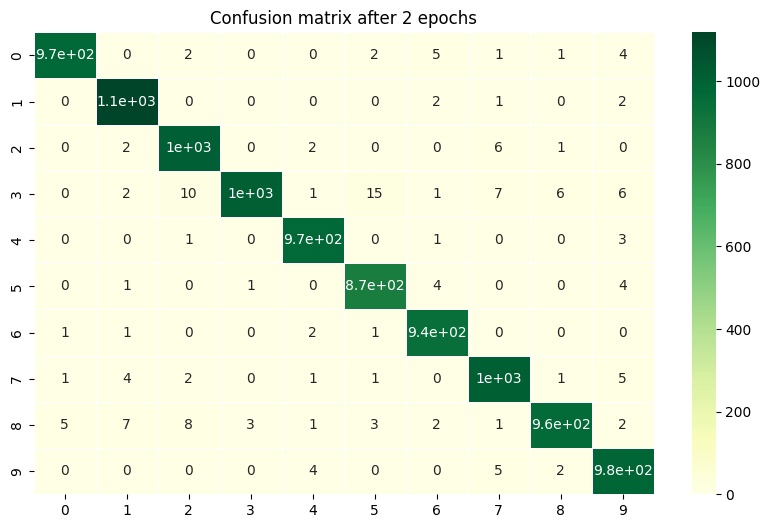

epoch 2 batch 0 [0/60000] training loss: 0.02526031993329525
epoch 2 batch 100 [10000/60000] training loss: 0.08253774791955948
epoch 2 batch 200 [20000/60000] training loss: 0.0735253393650055
epoch 2 batch 300 [30000/60000] training loss: 0.0865526795387268
epoch 2 batch 400 [40000/60000] training loss: 0.02387911081314087
epoch 2 batch 500 [50000/60000] training loss: 0.03764130547642708
Test Accuracy: 9887/10000 (tx 98.87%, err 1.13%)



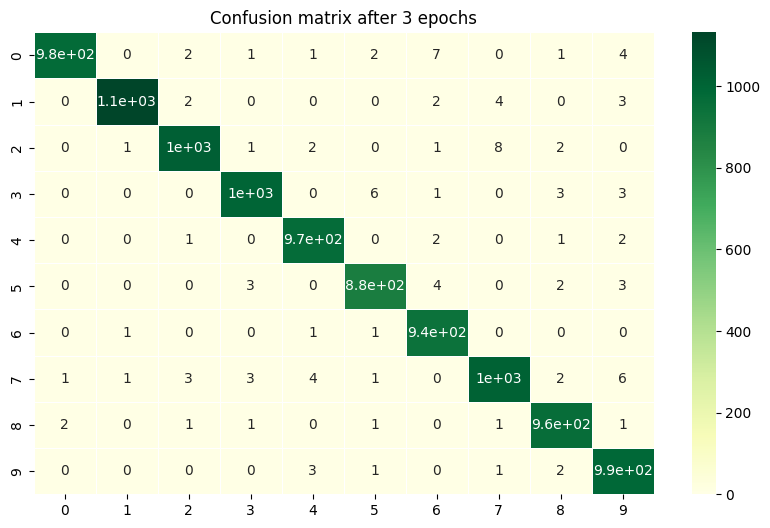

epoch 3 batch 0 [0/60000] training loss: 0.006841233465820551
epoch 3 batch 100 [10000/60000] training loss: 0.02545464038848877
epoch 3 batch 200 [20000/60000] training loss: 0.053395289927721024
epoch 3 batch 300 [30000/60000] training loss: 0.07475094497203827
epoch 3 batch 400 [40000/60000] training loss: 0.09600761532783508
epoch 3 batch 500 [50000/60000] training loss: 0.007269766181707382
Test Accuracy: 9898/10000 (tx 98.98%, err 1.02%)



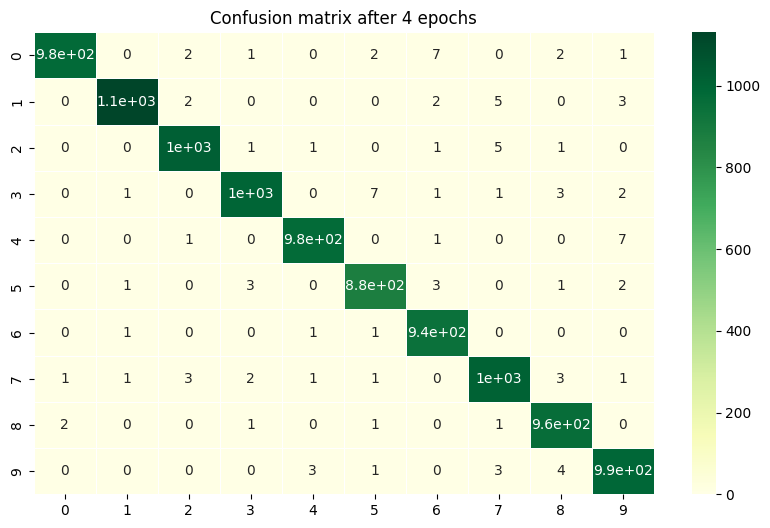

epoch 4 batch 0 [0/60000] training loss: 0.023150108754634857
epoch 4 batch 100 [10000/60000] training loss: 0.02944261021912098
epoch 4 batch 200 [20000/60000] training loss: 0.00963057391345501
epoch 4 batch 300 [30000/60000] training loss: 0.07509757578372955
epoch 4 batch 400 [40000/60000] training loss: 0.014612240716814995
epoch 4 batch 500 [50000/60000] training loss: 0.007785025984048843
Test Accuracy: 9898/10000 (tx 98.98%, err 1.02%)



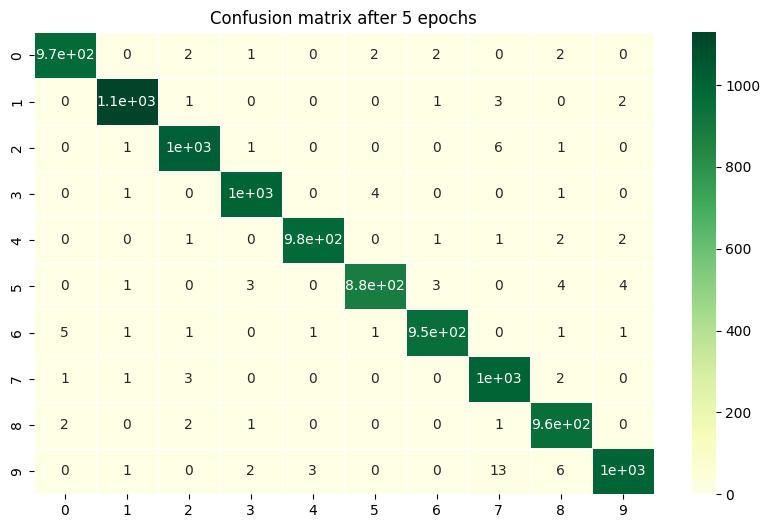

epoch 5 batch 0 [0/60000] training loss: 0.04156407713890076
epoch 5 batch 100 [10000/60000] training loss: 0.010754390619695187
epoch 5 batch 200 [20000/60000] training loss: 0.01947855018079281
epoch 5 batch 300 [30000/60000] training loss: 0.03692207485437393
epoch 5 batch 400 [40000/60000] training loss: 0.003964281640946865
epoch 5 batch 500 [50000/60000] training loss: 0.021673647686839104
Test Accuracy: 9913/10000 (tx 99.13%, err 0.87%)



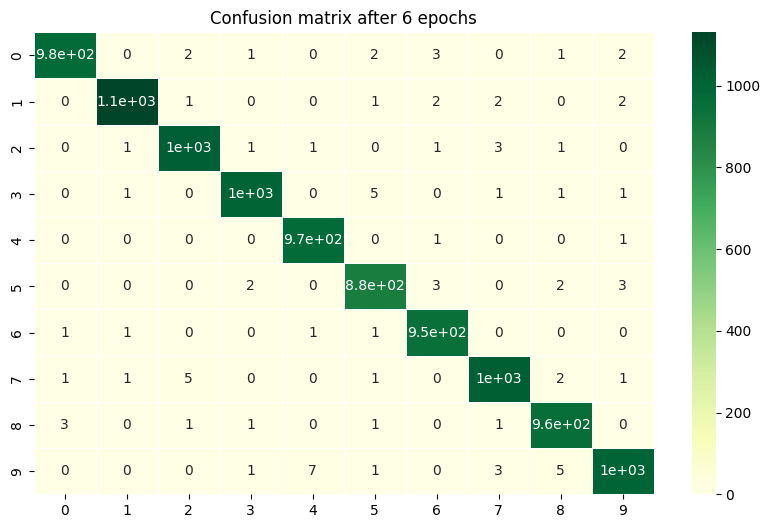

epoch 6 batch 0 [0/60000] training loss: 0.008066566661000252
epoch 6 batch 100 [10000/60000] training loss: 0.04120626300573349
epoch 6 batch 200 [20000/60000] training loss: 0.04506932199001312
epoch 6 batch 300 [30000/60000] training loss: 0.005170843563973904
epoch 6 batch 400 [40000/60000] training loss: 0.005533190444111824
epoch 6 batch 500 [50000/60000] training loss: 0.01644555851817131
Test Accuracy: 9905/10000 (tx 99.05%, err 0.95%)



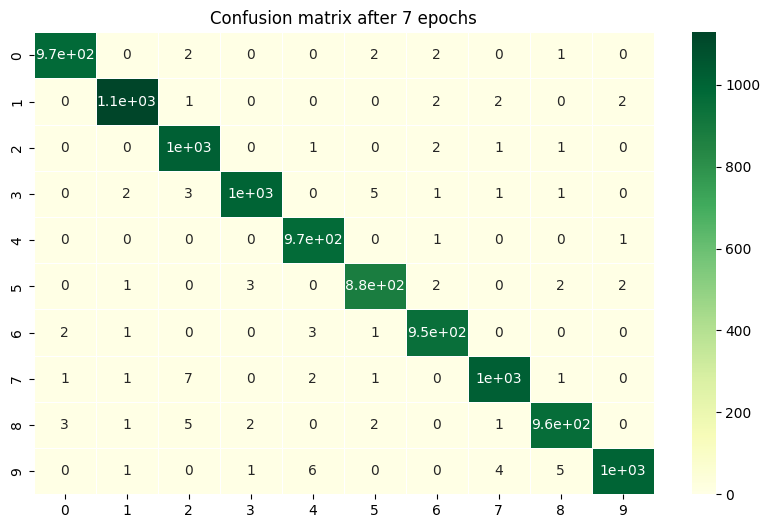

epoch 7 batch 0 [0/60000] training loss: 0.0039346106350421906
epoch 7 batch 100 [10000/60000] training loss: 0.0017112285131588578
epoch 7 batch 200 [20000/60000] training loss: 0.012288306839764118
epoch 7 batch 300 [30000/60000] training loss: 0.016846442595124245
epoch 7 batch 400 [40000/60000] training loss: 0.021851275116205215
epoch 7 batch 500 [50000/60000] training loss: 0.012053090147674084
Test Accuracy: 9916/10000 (tx 99.16%, err 0.84%)



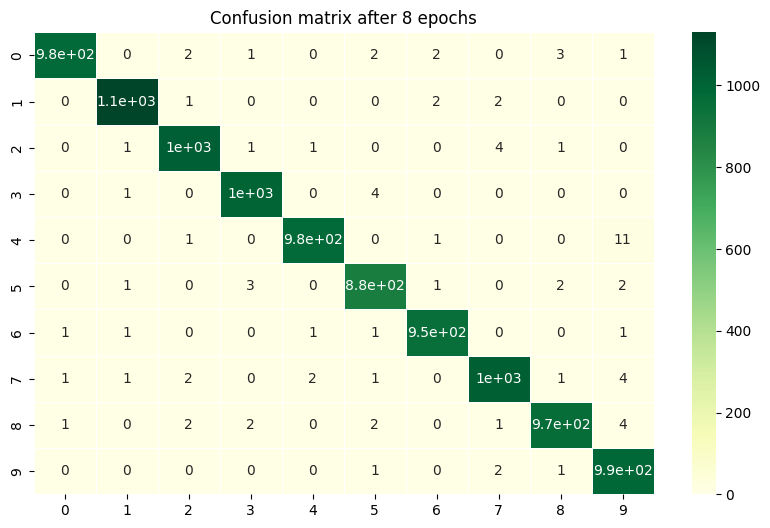

epoch 8 batch 0 [0/60000] training loss: 0.023737793788313866
epoch 8 batch 100 [10000/60000] training loss: 0.0015578619204461575
epoch 8 batch 200 [20000/60000] training loss: 0.02591545879840851
epoch 8 batch 300 [30000/60000] training loss: 0.021226894110441208
epoch 8 batch 400 [40000/60000] training loss: 0.028368880972266197
epoch 8 batch 500 [50000/60000] training loss: 0.02762709930539131
Test Accuracy: 9916/10000 (tx 99.16%, err 0.84%)



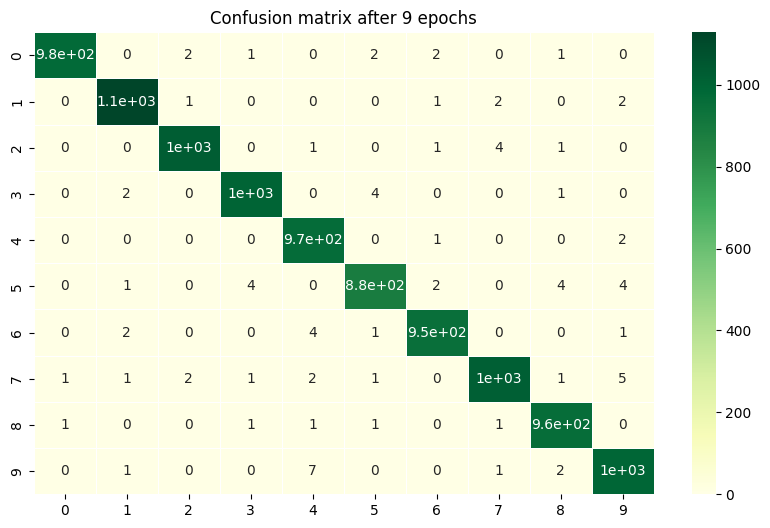

epoch 9 batch 0 [0/60000] training loss: 0.011805778369307518
epoch 9 batch 100 [10000/60000] training loss: 0.009306389838457108
epoch 9 batch 200 [20000/60000] training loss: 0.0010340118315070868
epoch 9 batch 300 [30000/60000] training loss: 0.010567229241132736
epoch 9 batch 400 [40000/60000] training loss: 0.002363733248785138
epoch 9 batch 500 [50000/60000] training loss: 0.012820947915315628
Test Accuracy: 9908/10000 (tx 99.08%, err 0.92%)



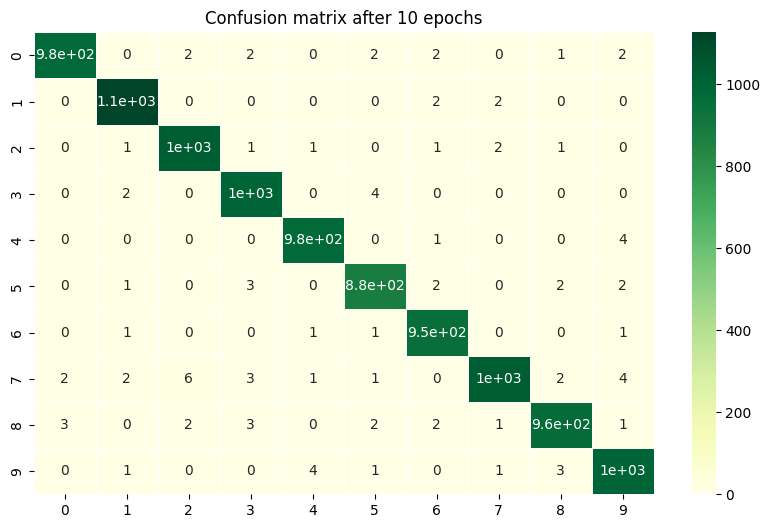

In [19]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    #print(confusion)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(confusion, annot=True,  linewidths=.5, cmap='YlGn')
    plt.title(f"Confusion matrix after {epoch+1} epochs")
    plt.show()
    plt.close()

__Calcul de la taille d'un modèle__

In [18]:
# parametres + buffers (e.g. batch norm)

def get_model_size(model):
    """ 
    in megabites --> divide by 1024**2
    """
    param_size = 0
    for p in model.parameters() :
        param_size += p.numel()*p.element_size()

    buffer_size = 0
    for b in model.buffers() :
        buffer_size += b.numel()*b.element_size()

    return (param_size + buffer_size) / 1024**2

print(round(get_model_size(model),3), "MB")

0.652 MB


In [19]:
#variantes (nombre de params) --> sélection suivant requires_grad

def count_trainable_parameters(model):
    """ count the number of trainable parameters""" 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_all_parameters(model):
    """ count the number of parameters, trainable or not""" 
    return sum(p.numel() for p in model.parameters())

print(count_trainable_parameters(model))
print(count_all_parameters(model))


170790
170790


__Sauvegarde des poids du modèle__

Il y a deux manières de sauvegarder un modèle suivant si on utilise `state_dict()` ou pas. Comparer avec la [documentation PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

> A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

In [20]:
# sauvegarde
print(model)
torch.save(model, 'my_cnn.pth')

# chargement
model1 = torch.load('./my_cnn.pth')
print(model1)

CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)
CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)


In [21]:
# Utilisation de state_dict : on accède aux paramètres du modèle

# sauvegarde
print(model.state_dict().keys())
torch.save(model.state_dict(), 'my_cnn_params.pth')

# chargement : il faut définir le modèle puis charger les poids
model2 = CNNNet()
model2.load_state_dict(torch.load('my_cnn_params.pth'))
print(model2)

odict_keys(['conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'fc_1.weight', 'fc_1.bias', 'fc_2.weight', 'fc_2.bias'])
CNNNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=10, bias=True)
)


__Visualisation des feature maps (cartes d'activation)__

Se référer au script `visualize_cnn_features.py`. Il utilise les poids du CNN, que l'on vient de sauvegarder. 

Autres références pour visualiser les cartes d'activation d'un CNN : [un réseau plus profond](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)  et [une autre méthode de visualisation](https://blbadger.github.io/feature-visualization.html) (en optimisant l'entrée de manière à maximiser la réponse d'un filtre donné).

### Modèles LSTM et Bi-LSTM

Se référer à la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) pour le module `LSTM`.

__LSTM__

In [22]:
# Hyper-parameters
sequence_length = 28 # on voit une image comme une chaine de 28 mots
input_size = 28 # chaque mot fait 28 caractères
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.001

In [23]:
# define LSTM model
class LSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(LSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True)
        self.fc = nn.Linear(hidden_size,nb_classes)

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [24]:
model = LSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()


In [25]:
import time 

# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )



Epoch [1/2], Step [100/600], Loss: 0.2766 (8.19 s)
Epoch [1/2], Step [200/600], Loss: 0.2464 (16.45 s)
Epoch [1/2], Step [300/600], Loss: 0.0957 (24.33 s)
Epoch [1/2], Step [400/600], Loss: 0.1044 (32.30 s)
Epoch [1/2], Step [500/600], Loss: 0.2041 (40.15 s)
Epoch [1/2], Step [600/600], Loss: 0.1333 (47.87 s)
Epoch [2/2], Step [100/600], Loss: 0.0443 (55.42 s)
Epoch [2/2], Step [200/600], Loss: 0.1808 (63.33 s)
Epoch [2/2], Step [300/600], Loss: 0.1482 (71.22 s)
Epoch [2/2], Step [400/600], Loss: 0.0739 (78.97 s)
Epoch [2/2], Step [500/600], Loss: 0.1761 (86.87 s)
Epoch [2/2], Step [600/600], Loss: 0.1768 (94.74 s)
Test Accuracy: 97.11%


__BiLSTM__

On passe l'option "bidirectional" à "True" dans nn.LSTM, et on adapte les dimensions des tenseurs dans le réseau.

In [26]:
learning_rate = 0.0005 # for BiLSTM

In [27]:
# define BiLSTM model
class BiLSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(BiLSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2,nb_classes)  # 2 for bidirection

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [28]:
model = BiLSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [29]:
# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )

Epoch [1/2], Step [100/600], Loss: 0.3756 (11.69 s)
Epoch [1/2], Step [200/600], Loss: 0.1829 (22.92 s)
Epoch [1/2], Step [300/600], Loss: 0.0595 (33.73 s)
Epoch [1/2], Step [400/600], Loss: 0.1961 (45.05 s)
Epoch [1/2], Step [500/600], Loss: 0.1752 (56.02 s)
Epoch [1/2], Step [600/600], Loss: 0.2056 (67.15 s)
Epoch [2/2], Step [100/600], Loss: 0.3366 (79.05 s)
Epoch [2/2], Step [200/600], Loss: 0.1145 (90.83 s)
Epoch [2/2], Step [300/600], Loss: 0.1488 (102.30 s)
Epoch [2/2], Step [400/600], Loss: 0.0795 (114.22 s)
Epoch [2/2], Step [500/600], Loss: 0.1376 (125.41 s)
Epoch [2/2], Step [600/600], Loss: 0.2321 (136.88 s)
Test Accuracy: 96.15%
